# Results


## CUB200 InceptionV3 Features (SVM)



*Small Reminder:* Baseline should be the same for all setups. Otherwise, something is wrong with the features!

| Part Type | # parts | Global part only<br> <small>*Baseline*</small> | All parts | All parts<br> <small>*Local parts shuffled*</small> | Local parts only | Local parts only<br>  <small>*Local parts shuffled*</small>  |
|-|-|-|-|-|-|-|
|  GT Parts | 15 | 88.47 % | **89.82 %** | 86.92¹ % | 87.95 % | 83.33¹ % |
| GT2 Parts | 4  | 88.47 % | **90.13 %** | 88.38¹ % | 86.80 % | 80.31¹ % |
| NAC Parts | 20 | 88.47 % | **89.09 %** | 87.49¹ % | 87.94 % | 85.12¹ % |
| L1P Parts | 4  | 88.47 % | **89.47 %** | 89.35¹ % | 87.45 % | 87.80¹ % |
| L1F Parts | 4  | 88.47 % | **89.13 %** | 88.80¹ % | 87.04 % | 87.19¹ % |

### LogisticRegression Baseline:
|Feature scale|C|Accuracy|
|-|-|-|
| no | 0.1 | 89.42 % | 
| no | 1 | 89.11 % | 
| yes | 1 | 89.37 % | 

## CUB200 InceptionV3_TF Features (SVM)


| Part Type | # parts | Global part only<br> <small>*Baseline*</small> | All parts | All parts<br> <small>*Local parts shuffled*</small> | Local parts only | Local parts only<br>  <small>*Local parts shuffled*</small>  |
|-|-|-|-|-|-|-|
|  GT Parts | 15 | 88.51 % | **89.82 %** | 86.68¹ % | 87.87 % | 82.69¹ % |
| GT2 Parts | 4  | 88.51 % | **90.18 %** | 87.68¹ % | 86.92 % | 80.20¹ % |
| NAC Parts | 20 | 88.51 % | **89.02 %** | 87.31¹ % | 87.92 % | 84.83¹ % |
| L1P Parts | 4  | 88.51 % | **89.45 %** | 89.23¹ % | 87.44 % | 87.33¹ % |
| L1F Parts | 4  | 88.51 % | **89.09 %** | 89.18¹ % | 86.99 % | 87.31¹ % |

¹ - needs more runs, since randomness involved




In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import joblib

from os.path import join
from matplotlib import pyplot as plt
from jupyter_utils.progress_bar import ProgressBar
from functools import partial

from nabirds.annotations import AnnotationType

from sklearn.svm import LinearSVC
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import cross_val_score

# Load data

In [17]:
BASE_DIR = "/home/korsch/Data"

# inception inception_tf resnet
FEATURE_MODEL = "inception"

# CUB200, CARS
DATASET = "CUB200"

# GLOBAL NAC GT GT2 L1_pred L1_full
PARTS = "GLOBAL"

KEY = "{}.{}.{}".format(DATASET, PARTS, FEATURE_MODEL)

DUMP = False

In [4]:
annot_cls = AnnotationType.get(DATASET).value
info = join(BASE_DIR, "info.yml")

print("Loading {} annotations from \"{}\"...".format(
    annot_cls.__name__, info))

annot = annot_cls(info, 
    parts="{}_{}".format(DATASET, PARTS),
    feature_model=FEATURE_MODEL
)

Loading CUB_Annotations annotations from "/home/korsch/Data/info.yml"...


In [5]:
train, val = [annot.new_dataset(subset) for subset in ["train", "test"]]

print("Loaded {} train and {} test images".format(len(train), len(val)))

train_feats = train.features
val_feats = val.features

print("Feature shapes: {} / {}".format(train_feats.shape, val_feats.shape))

assert train_feats is not None
assert val_feats is not None

Loaded 5994 train and 5794 test images
Feature shapes: (5994, 1, 2048) / (5794, 1, 2048)


In [6]:
def evaluate(X, y, X_val, y_val, clf_class=LinearSVC, scale=False):
    print(X.shape, X_val.shape)
    print(y, y_val)
    
    if scale:
        print("Scaling Data...")
        scaler = MinMaxScaler()
        X = scaler.fit_transform(X)
        X_val = scaler.transform(X_val)
    clf = clf_class()
    
    #print(cross_val_score(clf, X, y, cv=3, n_jobs=3))
    
    print("Training {0.__class__.__name__} Classifier...".format(clf))
    %time clf.fit(X, y)
    return clf, clf.score(X_val, y_val)

# Some Feature Stats

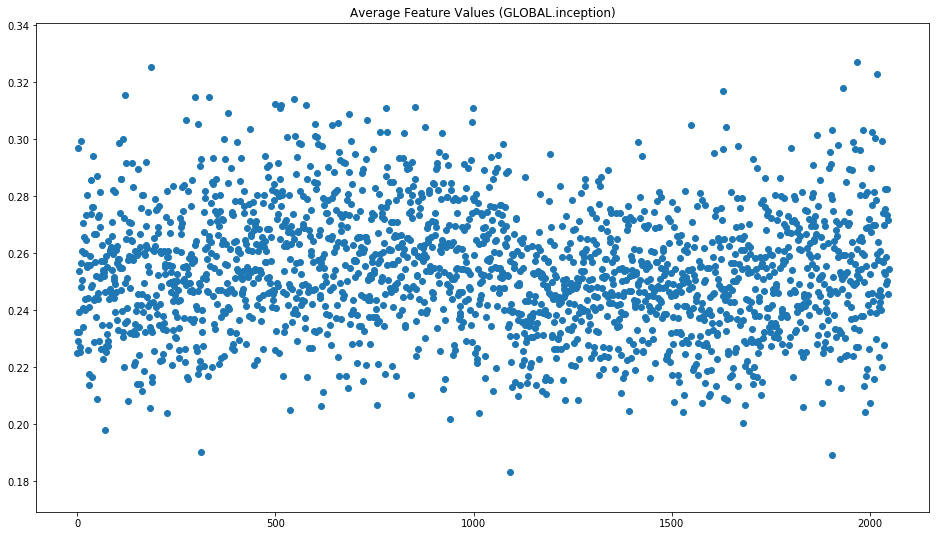

In [7]:
fig, ax = plt.subplots(figsize=(16,9))
ax.scatter(range(train_feats.shape[-1]), train_feats.mean(axis=(0,1)))
ax.set_title("Average Feature Values ({})".format(KEY))
plt.show()

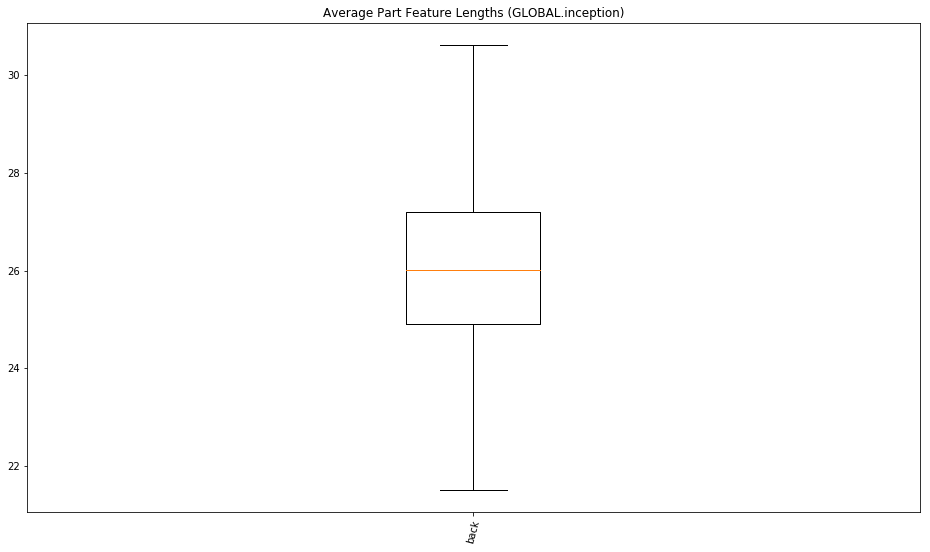

In [8]:
import matplotlib.pyplot as plt

feature_norms = np.sqrt(np.sum(train_feats ** 2, axis=-1))
fig, ax = plt.subplots(figsize=(16,9))
ax.set_title("Average Part Feature Lengths ({})".format(KEY))
ax.boxplot(feature_norms, showfliers=False)

if hasattr(train._annot, "part_name_list"):
    part_names = list(train._annot.part_name_list)
    if PARTS == "NAC":
        part_names *= 2
    part_names.append("GLOBAL")

    ax.set_xticklabels(part_names, rotation=75)
plt.show()

# Train SVM with sparse feature coefficients

In [18]:
X, y = train_feats[:, -1, :], train.labels
X_val, y_val = val_feats[:, -1, :], val.labels

clf_class = partial(LinearSVC, penalty="l1", C=0.1, dual=False, max_iter=1000)
# clf_class = partial(LogisticRegression, 
#                     C=1, 
#                     penalty="l1", 
#                     tol=0.0001, 
#                     solver="saga",
#                     multi_class="ovr"
#                    )
clf, score = evaluate(X, y, X_val, y_val, clf_class, scale=True)

print("{:.2%}".format(score))
if DUMP:
    joblib.dump(clf, "clf_{}_glob_only_sparse_coefs.npz".format(KEY))
    

(5994, 2048) (5794, 2048)
[  0   0   0 ... 199 199 199] [  0   0   0 ... 199 199 199]
Scaling Data...
Training LinearSVC Classifier...
CPU times: user 2min 47s, sys: 14.1 s, total: 3min 1s
Wall time: 3min
86.92%


In [19]:
joblib.dump(clf, "clf_{}_glob_only_sparse_coefs.npz".format(KEY))

['clf_CUB200.GLOBAL.inception_glob_only_sparse_coefs.npz']

-0.019462280050298864 0.5726410671968273


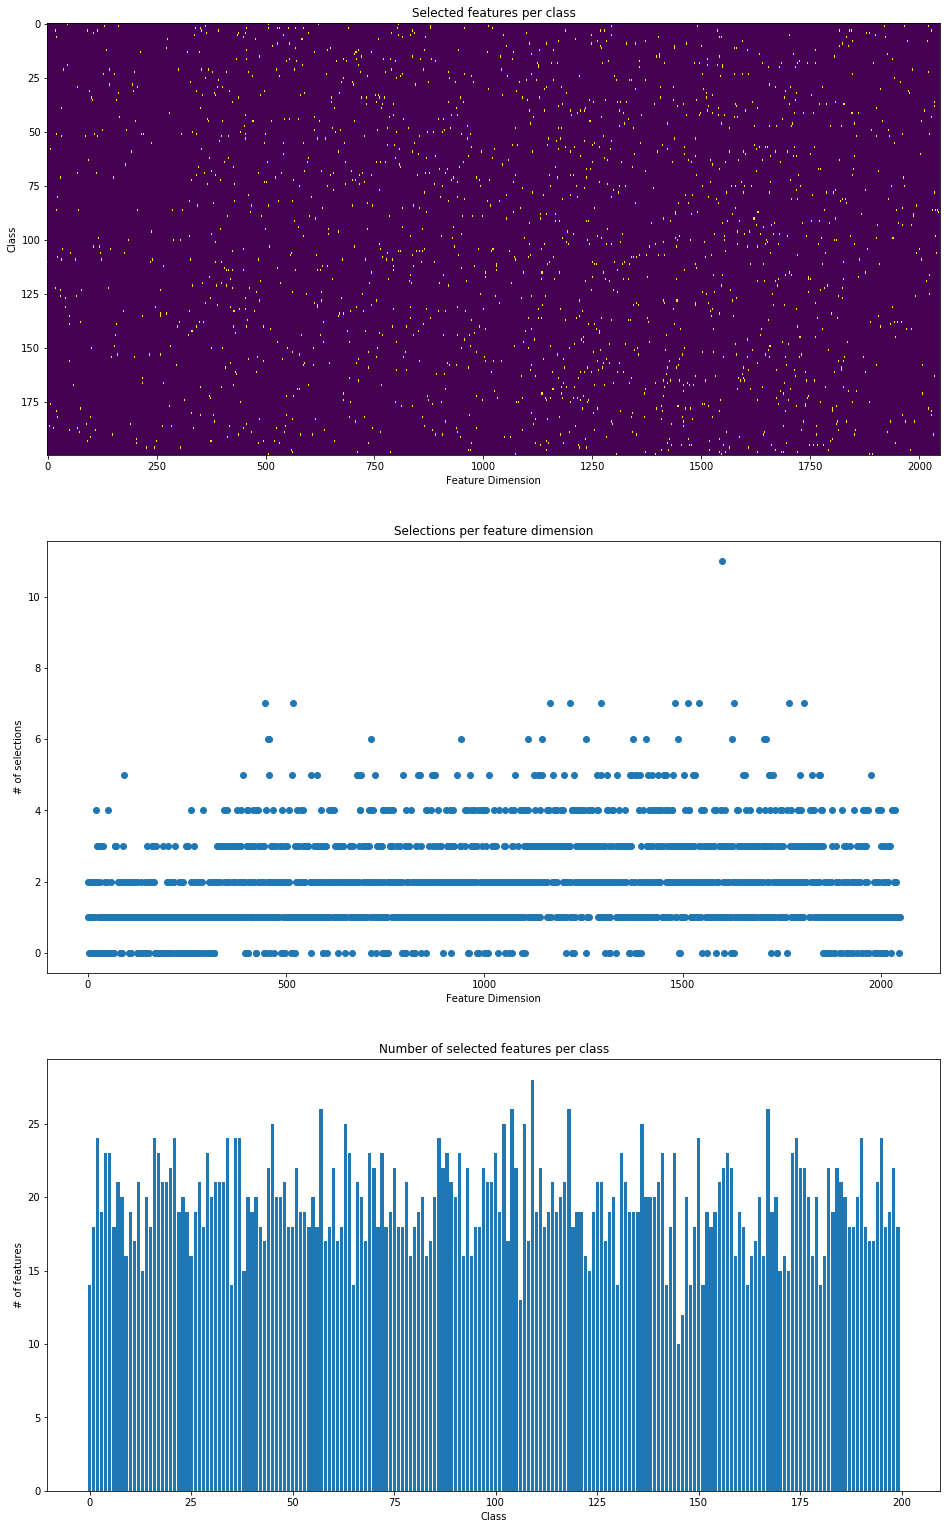

In [15]:
#clf = joblib.load("clf_{}_glob_only_sparse_coefs.npz".format(KEY))

print(clf.coef_.min(), clf.coef_.max())

fig, ax = plt.subplots(3, 1, figsize=(16, 9*3))
ax[0].set_title("Selected features per class")
ax[0].set_xlabel("Feature Dimension")
ax[0].set_ylabel("Class")
ax[0].imshow(clf.coef_ != 0, aspect="auto")

ax[1].set_title("Selections per feature dimension")
ax[1].set_xlabel("Feature Dimension")
ax[1].set_ylabel("# of selections")
# ax[1].imshow((clf.coef_ != 0).sum(axis=0, keepdims=True), aspect="auto")
ax[1].scatter(range(clf.coef_.shape[1]), (clf.coef_ != 0).sum(axis=0))

ax[2].set_title("Number of selected features per class")
ax[2].set_xlabel("Class")
ax[2].set_ylabel("# of features")
ax[2].bar(range(len(clf.coef_)), (clf.coef_ != 0).sum(axis=1))
plt.show()
plt.close()

print()

# Train LogRegressor classifier on global part only

In [11]:
X, y = train_feats[:, -1, :], train.labels
X_val, y_val = val_feats[:, -1, :], val.labels

clf_class = partial(LogisticRegression, 
                    C=0.01,
                    solver='lbfgs', 
                    multi_class='multinomial', 
                    max_iter=500)

clf, score = evaluate(X, y, X_val, y_val, clf_class, scale=False)
print("{:.2%}".format(score))

(5994, 2048) (5794, 2048)
[  0   0   0 ... 199 199 199] [  0   0   0 ... 199 199 199]
Training LogisticRegression Classifier...
CPU times: user 34.7 s, sys: 964 ms, total: 35.7 s
Wall time: 9.18 s
87.18%


In [10]:
raise StopIteration

StopIteration: 

# Train SVM on global part only

In [ ]:
X, y = train_feats[:, -1, :], train.labels
X_val, y_val = val_feats[:, -1, :], val.labels

clf, score = evaluate(X, y, X_val, y_val, scale=True)
print("{:.2%}".format(score))
if DUMP:
    joblib.dump(clf, "clf_{}_glob_only.npz".format(KEY))

# Train SVM on all parts

In [ ]:
X, y = train_feats.reshape(len(train), -1), train.labels
X_val, y_val = val_feats.reshape(len(val), -1), val.labels

# clf_class = partial(LogisticRegression, 
#                     C=1,
#                     solver='lbfgs', 
#                     multi_class='multinomial',
#                     max_iter=300)
clf_class = LinearSVC
clf, score = evaluate(X, y, X_val, y_val, clf_class, scale=True)
print("{:.2%}".format(score))
if DUMP:
    joblib.dump(clf, "clf_{}_all_parts.npz".format(KEY))

# Train SVM on local parts only

In [ ]:
X, y = train_feats[:, :-1, :].reshape(len(train), -1), train.labels
X_val, y_val = val_feats[:, :-1, :].reshape(len(val), -1), val.labels

clf, score = evaluate(X, y, X_val, y_val, clf_class, scale=True)
print("{:.2%}".format(score))
if DUMP:
    joblib.dump(clf, "clf_{}_local_parts.npz".format(KEY))

# Shuffle Part Positions

Shuffle parts for each sample. Leave global feature on the correct place.

In [ ]:
train_feats_rnd = train_feats.copy()
val_feats_rnd = val_feats.copy()

bar = ProgressBar()

[np.random.shuffle(f[:-1]) for f in bar(train_feats_rnd)]
[np.random.shuffle(f[:-1]) for f in bar(val_feats_rnd)]

print("shuffling ready")

# Train SVM on all parts

In [ ]:
X, y = train_feats_rnd.reshape(len(train), -1), train.labels
X_val, y_val = val_feats_rnd.reshape(len(val), -1), val.labels

clf, score = evaluate(X, y, X_val, y_val, clf_class, scale=True)
print("{:.2%}".format(score))
if DUMP:
    joblib.dump(clf, "clf_{}_all_parts_shuffled.npz".format(KEY))

# Train SVM on local parts only

In [ ]:
X, y = train_feats_rnd[:, :-1, :].reshape(len(train), -1), train.labels
X_val, y_val = val_feats_rnd[:, :-1, :].reshape(len(val), -1), val.labels

clf, score = evaluate(X, y, X_val, y_val, clf_class, scale=True)
print("{:.2%}".format(score))
if DUMP:
    joblib.dump(clf, "clf_{}_local_parts_shuffled.npz".format(KEY))

# Old Cells